Following CRISP-DM.

- Business understanding – What does the business need?
The business need to predict customer behaviour and based on that to recommend potential articles with horizon of 7 days and length of 12 top products.

- Data understanding – What data do we have / need? Is it clean?
We will need transactions data as well as articles and customers details. The data is scaled, pseudonymized and structured but still need some cleaning because it contains fair amount of NaN values in some of the features.
- Data preparation – How do we organize the data for modeling?
Join all the data at single dataframe, potentially if we have big data using pyspark and RDDs. Use vectorization operations with priority because of the large data volume.
- Modeling – What modeling techniques should we apply?
Modeling based on statistical clustering and pre-trained NN models(CNN feature extractions) provided by tensorflow.
- Evaluation – Which model best meets the business objectives?
The model with best Mean Average Precision of the up to 12 articles(labels) per single customer as recommended.
- Deployment – How do stakeholders access the results?
Potentially the project can be presented in front-end like Tablaeu or Power BI for client ease of use.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mping
from itertools import *
import random
from multiprocessing import Pool
from keras_preprocessing.image import ImageDataGenerator
import seaborn as sns

In [2]:
tran_raw = pd.read_csv('transactions_train.csv')
customers_raw = pd.read_csv('customers.csv')
articles_raw = pd.read_csv('articles.csv')

In [3]:
# Overview
display('transactions', tran_raw.head(), tran_raw.info()) , display('cust', customers_raw.head(), customers_raw.info()), display('articles', articles_raw.head(2), articles_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


'transactions'

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


'cust'

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

'articles'

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


None

(None, None, None)

In [4]:
# Single customer history
tran_raw[tran_raw.customer_id == tran_raw.customer_id.unique()[42]]

,t_dat,customer_id,article_id,price,sales_channel_id
135,2018-09-20,00b5b1446be091d4913765cf2cc01edc7e0d3820e1b8a4...,627300001,0.024136,2
136,2018-09-20,00b5b1446be091d4913765cf2cc01edc7e0d3820e1b8a4...,544360001,0.011847,2


Quick notes:
- dates are sorted
- prices are scaled but check for outliers with std and use them to create price_range var

Brainstorming:

Ideas on how to recommend product to customers.
- Each customer have specific choices based on sex(colors and fit), age(generation trends), location(avg air tempreture), preferences(products with particular features think CNN feature extraction), date(if seasonal; group_by date and cust_id.count() of the items bought).
- Ideally customers should be clearly separated by sex preferences.

High level plan:
- Explore articles data and customers
- Encode transactions df based on their sex, age group and location (but first analyze their transactions with the help of articles joint table).
- Joining customer info data to transactions **note** create age_range column before joining.

Questions:
- Is it good idea to train whole dataset if some customers have only just a few transactions and no actual data(measure the error per history length).
Solution-Filter out clients with the most history available for the sace of simplicity.

#### Explore

In [5]:
# Article segments
articles_raw.index_group_name.value_counts()

Ladieswear       39737
Baby/Children    34711
Divided          15149
Menswear         12553
Sport             3392
Name: index_group_name, dtype: int64

Most of the items are woman's ware. Question: Can we conclude the sex of the customer only by woman's ware purchases?

In [6]:
len(articles_raw[articles_raw.index_name == 'Ladieswear']) / len(articles_raw), '% Ladiesware'

(0.24635690057038903, '% Ladiesware')

<AxesSubplot:xlabel='Count', ylabel='garment_group_name'>

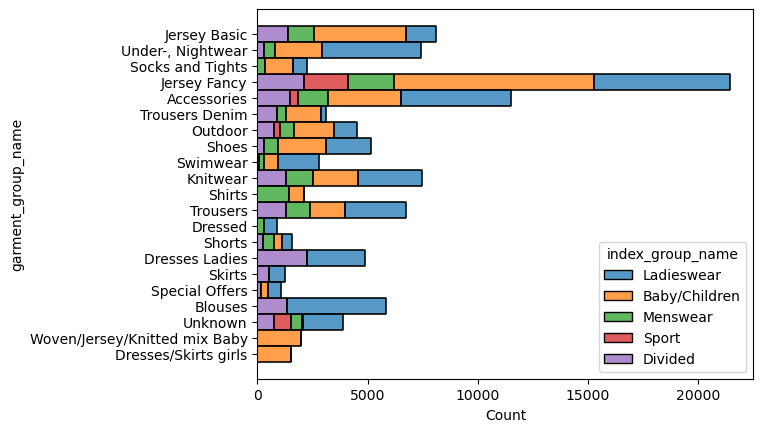

In [7]:
sns.histplot(data=articles_raw, y='garment_group_name', hue='index_group_name', multiple='stack')

Those features can be used in image multi labeling Ex. ['Ladieswear', 'Shoes', Black], ['Menswear', 'Swimwear', Blue] and etc.

#### Organize to dataframe / Feature engineering

Feature engineering:
- Include sex segment of the articles count bought by the person (not straight forward: ex. Women can buy baby/man clothes)
- Include age range as additional feature

Obstacle:
- currently merging all of articles_raw into tran_raw causes memory overflow.(use spark/pyspark on a cluster)

Observations:
- customer data have null values for columns "Active" and "FN"
- there are 423 177 single customers that have 21d or more transactions data (still too much to use local memory) (will use treshold of >= 500d of data)

Ideas:
- to be memory efficient create dict that maps classes to str names of the articles for result interpretation
- introduce age range as a feature then merge customers data to transactions (Find ranges Google: Recommended for all products that vary by age)

In [8]:
# Filter out customers to fit memory
x = pd.DataFrame(tran_raw['customer_id'].value_counts())
x = x[x.customer_id >= 500]
x = pd.DataFrame(x.index)
x.columns = ['customer_id']  # to filter

# Join table right
trans_filter = tran_raw.merge(x, on='customer_id', how='right')
len(trans_filter)

307782

In [9]:
# Create age_range (3 classes) (feature engineering)
customers_raw.loc[customers_raw.eval('0 <= age < 12'), 'age_range'] = 1
customers_raw.loc[customers_raw.eval('13 <= age < 24'), 'age_range'] = 2
customers_raw.loc[customers_raw.eval('24 <= age'), 'age_range'] = 3

In [10]:
# Price analysis 
tran_raw.price.describe()

count    3.178832e+07
mean     2.782927e-02
std      1.918113e-02
min      1.694915e-05
25%      1.581356e-02
50%      2.540678e-02
75%      3.388136e-02
max      5.915254e-01
Name: price, dtype: float64

In [11]:
# Create price_range by quantile (3 classes) (feature engineering)
trans_filter.loc[trans_filter.eval('price < 1.581356e-02'), 'price_range'] = 1  # cheap
trans_filter.loc[trans_filter.eval('1.581356e-02 <= price < 2.540678e-02'), 'price_range'] = 2  # mid
trans_filter.loc[trans_filter.eval('2.540678e-02 <= price'), 'price_range'] = 3  # expensive

In [12]:
# Articles to transactions
tran_df = trans_filter.merge(articles_raw, on='article_id', how='left')

# Customer data to transactions (incl. Age_range)
tran_df = tran_df.merge(customers_raw, on='customer_id', how='left')

In [13]:
# del articles_raw
# del customers_raw

In [14]:
# Artical ID by segment (customer segmentation)
mask = articles_raw.index_group_name
segment = articles_raw.index_group_name.unique()

article_segments = []
for i in segment:
    x = articles_raw[mask == i].article_id.unique()
    article_segments.append([i, x])
article_segments = pd.DataFrame(article_segments, columns=['segment', 'article_id'])
article_segments

,segment,article_id
0,Ladieswear,"[108775015, 108775044, 108775051, 110065001, 1..."
1,Baby/Children,"[112679048, 112679052, 141661022, 141661025, 1..."
2,Menswear,"[118458003, 118458004, 118458028, 118458029, 1..."
3,Sport,"[145872001, 145872037, 145872043, 145872051, 1..."
4,Divided,"[162074062, 162074069, 162074071, 181160009, 1..."


In [15]:
# All transactions per customer organized
tran_hist = tran_df.groupby('customer_id')['article_id'].agg(list)
tran_hist = pd.DataFrame(tran_hist).reset_index()
tran_hist

,customer_id,article_id
0,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"[568931008, 568931008, 663016003, 522461002, 3..."
1,00357b192b81fc83261a45be87f5f3d59112db7d117513...,"[625939013, 625939013, 712838007, 565379001, 6..."
2,00eebac2c2e37626461e74e8395711964c4e01a7afa643...,"[617878001, 622162001, 634716003, 591201001, 5..."
3,0152d53f51444891ea07013fd1fb8325415bb09bb6798a...,"[554450019, 512251006, 189691063, 519749039, 5..."
4,01661bad253b21353092eaf49836913843e1fc0554a674...,"[633130002, 633136007, 633130015, 625773001, 5..."
...,...,...
473,fef395784b1cbc27962e186a7ab7601026d1b88e38d018...,"[649397001, 649397001, 570579007, 574109012, 5..."
474,ff10db7cc350e8a9751875f1437af699c7ed70e0cc241e...,"[626263024, 623840002, 617102002, 626263006, 5..."
475,ffbc3eed3d16c3e07668b5ef88a605fdae56d857e98972...,"[636077001, 690276001, 542991002, 690276002, 5..."
476,ffc247b933f175b37fccbb4f71c0479d6625e703b36f63...,"[188183001, 562245005, 573716039, 576773009, 6..."


Note: We should translate the article_id into class number in order to be suitable for training.

In [16]:
# Find sex per customer (feature engineering)
'''Here we assign sex based on frequency of 
transacted articles.
To do: Babies to be assigned as ladies[0]
(potentially also accounting for only ladies age >= 18). 
'''
sex_map = []
for i in range(len(tran_hist)):
    cust_id = tran_hist.loc[i][0]  # customer id
    tran = pd.Series(tran_hist.loc[i][1])
    w = (tran.isin(article_segments.loc[0][1])).sum()  # Ladiesware articles [0]
    b = (tran.isin(article_segments.loc[1][1])).sum()  # Baby/Children [1]
    m = (tran.isin(article_segments.loc[2][1])).sum()  # Menswear [2]
    s = (tran.isin(article_segments.loc[3][1])).sum()  # Sport [3]
    d = (tran.isin(article_segments.loc[4][1])).sum()  # Divided [4]
    sums = [w, b, m, s, d]
    result = sums.index(max(sums))
    sex_map.append([cust_id, result])
sex_df = pd.DataFrame(sex_map)
sex_df.columns = ['customer_id', 'sex']

In [17]:
# Verify the feature is working correct
print('sum of category numbers: ', pd.DataFrame(sex_map)[1].sum())
print('max category int:', pd.DataFrame(sex_map)[1].max())

sum of category numbers:  99
max category int: 4


In [18]:
# Sex segmentation to transactions
tran_df = tran_df.merge(sex_df, on='customer_id', how='left')

In [19]:
# Create image file names to tran_df
image_list = []
for i in tran_df.article_id.astype(str):
    image_list.extend(['0' + i + '.jpg'])  # do we need folder_name/*.img?
tran_df['image_name'] = image_list

In [20]:
# Create image multi lables to tran_df
tran_df['multi_label'] = tran_df[['index_group_name', 'garment_group_name','perceived_colour_master_name', 'price_range']].agg(lambda x: [', '.join(x.astype(str))], axis=1)
display(tran_df.multi_label[:5])

# Expected number of classes (multi_label)
a = tran_df[['index_group_name', 'garment_group_name','perceived_colour_master_name', 'price_range']]
result = len(a.iloc[:,0].unique()) * len(a.iloc[:,1].unique()) * len(a.iloc[:,2].unique())
print("Number of multi label combinations: ", result)

0       [Divided, Trousers Denim, Blue, 3.0]
1          [Ladieswear, Knitwear, Grey, 3.0]
2      [Divided, Trousers Denim, Black, 3.0]
3    [Ladieswear, Special Offers, Grey, 2.0]
4    [Ladieswear, Special Offers, Grey, 2.0]
Name: multi_label, dtype: object

Number of multi label combinations:  2100


#### Cleaning

In [21]:
# Total amount of null values
print('null vals: ', tran_df.isnull().sum(axis=1).sum())
print('all vals:', tran_df.size)

null vals:  243004
all vals: 12311280


In [22]:
# Single table of data
tran_df.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'price_range', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'postal_code',
       'age_range', 'sex', 'image_name', 'multi_label'],
      dtype='object')

**Plan next steps:**

Option1: After we concluded that the data is too big (and will probably increase with time) to be pre-processed and trained on a single machine memory - Spark or Pyspark with cloud services should be used. (possible optimization with weights training checkpoints or transfer learning with pre-trained models)

Option2: If Spark does not provide sufficient MLlib option and Tensorflow could not be used with multiple workers - possible solution batch training and saving the weights of each y_pred formula then updating the weights with each batch of data until we train the whole data (use keras.callbacks.ModelCheckpoint).

If in a hurry, find a suitable model and refactor it to fit the current data structure and potentially solve the problem. Otherwise build from scratch (probably a lot of time) and use pre-trained NN models for the image feature. Potential model for refactoring: https://github.com/sonu275981/Fashion-Recommender-system

**Modeling:**

Form hypothesis:
 - At very low level - what one person bought and what are the same items alternatives that he can potentially buy in the next 7 calendar days. They will be best explained by images or clustering by feature_range with unsupervised learning algorithm ensemble.

Notes:
- Data analysis for statistical significance testing.


**Brainstorming:**
- If we have evey customer purchase in a list organized in "tran_hist" variable we can use NN with images to recommend features of similar products with horizon 7(days) and length 12(articles).
- customer_id OHE or using tran_hist style dataframe
- revolve around autocorrelation becuase single article should be the reason to add another item to form complete outlook.
 - High level training plan: Use NN with input t_{-7} and output t_{0} in order to learn autocorrelation patterns. The output nodes will be with len((article_id).unique()) and after the fitting while testing the horizon we will take the top/nlargest 12 reccomendations by percentage probablity and assign them to the customer_id.
 - Low level training plan: Input data should be daily aggregated(fix problem with multiple transactions in a day) will consist of [customer_id, article_id[t-7], article_details, article image(1d/flatten)]; labels will consist of [article_id[t_0]]

#### Modeling


Idea: NLP additional model can be ansembled with tran_df.detail_desc of each article_id

Optional: Use transfer learning with VGG-16, take only features of each article image and perform k-means clustering.

Let NN + k-means find the best matching articles then map the classes to the articles and start testing the algorithm.

Then sort out related to the customer based on historical info 12 items.

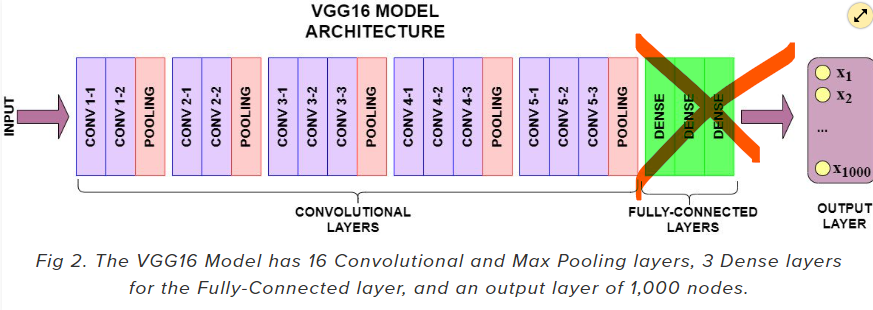

**Final: Following train from scratch - https://github.com/swapnasamirshukla/BT5153-Term-Project/blob/master/BT5153_AML_ImageSearch_CNNAutoEncoder.ipynb**

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator

In [24]:
# %pip install -U tensorflow --user -q
# %pip install numpy==1.21 --user -q
print(tf. __version__)

2.11.0


In [25]:
# Load dir of images
import glob
path = "images"
image_dirs = glob.glob(path + "/*/*.jpg", recursive=True)

In [28]:
cd images

d:\Databreath\images


image name = D:/Databreath/images/010/0108775015.jpg, image size = (1750, 1166, 3), image data type = uint8


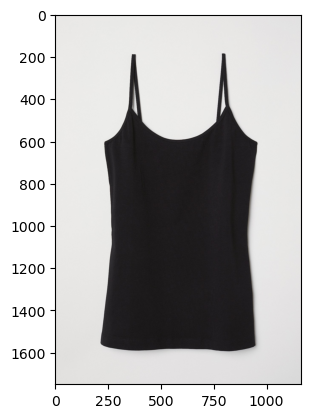

In [34]:
# Load single image
image_name = 'D:/Databreath/images/010/0108775015.jpg'
image = plt.imread(image_name)
plt.imshow(image)
print('image name = {}, image size = {}, image data type = {}'.format(image_name, image.shape, image.dtype))

In [35]:
# Create image_name articles_raw
image_list = []
for i in articles_raw.article_id.astype(str):
    image_list.extend(['0' + i[:2] + '/0' + i + '.jpg'])  # do we need folder_name/*.img?
articles_raw['image_name'] = image_list

In [36]:
# Create image multi lables in articles_raw
articles_raw['multi_label'] = articles_raw[['index_group_name', 'garment_group_name','perceived_colour_master_name']].agg(lambda x: [', '.join(x.astype(str))], axis=1)
display(articles_raw.multi_label[:5])

# Expected number of classes (multi_label)
a = articles_raw[['index_group_name', 'garment_group_name','perceived_colour_master_name']]
result = len(a.iloc[:,0].unique()) * len(a.iloc[:,1].unique()) * len(a.iloc[:,2].unique())
print("Number of multi label combinations: ", result)

0         [Ladieswear, Jersey Basic, Black]
1         [Ladieswear, Jersey Basic, White]
2         [Ladieswear, Jersey Basic, White]
3    [Ladieswear, Under-, Nightwear, Black]
4    [Ladieswear, Under-, Nightwear, White]
Name: multi_label, dtype: object

Number of multi label combinations:  2100


In [37]:
batch_size = 64
image_width = image.shape[0]
image_height = image.shape[1]

image_generator = ImageDataGenerator(rescale=1./255)
# we can't get the original image_name in original sequence

training_generator = image_generator.flow_from_dataframe(
    dataframe = articles_raw,
    directory = 'D:/Databreath/images/',
    x_col = 'image_name', # name.jpg
    y_col = 'multi_label', 
    target_size = (image_height, image_height),  # make squares
    batch_size = batch_size,  # default value
    class_mode = 'categorical',
    validate_filenames=True
    )


d:\ProgramFiles\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 442 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


Found 105100 validated image filenames belonging to 1131 classes.


In [38]:
train_samples = len(image_list)
total_steps = train_samples // batch_size
print(train_samples, total_steps)

105542 1649


In [39]:
import math
# getting the X features from generator
def features_matrix(generator, batch_size):
    number_of_examples = len(generator.filenames)
    number_of_generator_calls = math.ceil(number_of_examples / (1.0 * batch_size))
    features_matrix = []
    for i in range(0,int(number_of_generator_calls)):
        features_matrix.extend(np.array(generator[i][0]))
    return features_matrix

In [40]:
# Off-load memory
del tran_raw
del customers_raw
del image
del image_dirs
del tran_df

In [41]:
train_X =  features_matrix(training_generator, batch_size)
print('training X',len(train_X), train_X[0].shape)

MemoryError: Unable to allocate 996. MiB for an array with shape (64, 1166, 1166, 3) and data type float32

Not enough memory